In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap

In [35]:
random.seed(42)
np.random.seed(42)

numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']

In [55]:
# Loading the data
scaler = MinMaxScaler()

df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Finding the best hyperparameters for the model

In [56]:
model = LogisticRegression(penalty='l1', random_state=42, solver='saga', max_iter=10000)
param_grid = {'C': np.logspace(-3, 2, 50)}

grid_f1 = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(f1_score))
grid_f1.fit(X_train_val, y_train_val)
grid_balanced_accuracy = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(balanced_accuracy_score))
grid_balanced_accuracy.fit(X_train_val, y_train_val)

print(f"Best C (1/alpha) for f1 score: {grid_f1.best_params_['C']:.4f}")
print(f"Best F1 Score: {grid_f1.best_score_:.4f}")
print(f"\nBest C (1/alpha) for balanced accuracy: {grid_balanced_accuracy.best_params_['C']:.4f}")
print(f"Best balanced accuracy: {grid_balanced_accuracy.best_score_:.4f}")

Best C (1/alpha) for f1 score: 0.1099
Best F1 Score: 0.8575

Best C (1/alpha) for balanced accuracy: 0.0869
Best balanced accuracy: 0.8449


### Standard scaler
- Best C (1/alpha) for f1 score: 5.963623316594643
- Best F1 Score: 0.847153127052311

- Best C (1/alpha) for balanced accuracy: 5.963623316594643
- Best balanced accuracy: 0.8354790872517533

### Min-max scaler
- Best C (1/alpha) for f1 score: 0.13894954943731375
- Best F1 Score: 0.8592491300959104

- Best C (1/alpha) for balanced accuracy: 0.13894954943731375
- Best balanced accuracy: 0.8478671608450673

# Creating and training the model

In [57]:
model = LogisticRegression(C=grid_f1.best_params_['C'], penalty='l1', random_state=42, solver='saga', max_iter=10000)
model.fit(X_train_val, y_train_val)

LogisticRegression(C=0.10985411419875583, max_iter=10000, penalty='l1',
                   random_state=42, solver='saga')

In [58]:
y_pred = model.predict(X_test)
print(f'f1 score on test set: {f1_score(y_test, y_pred):.4f}\nBalanced accuracy score on test set: {balanced_accuracy_score(y_test, y_pred):.4f}')

f1 score on test set: 0.8622
Balanced accuracy score on test set: 0.8193


# Visualizing the parameters

/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_813/1506897800.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_coefs, x='variables', y='coefficients', palette="viridis")


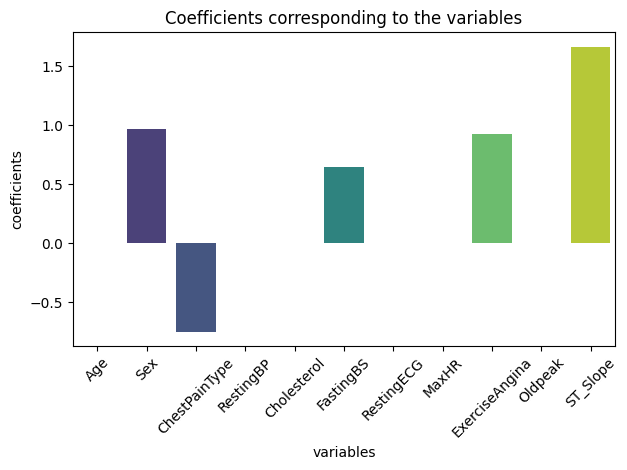

In [59]:
variables = df_test.columns.drop('HeartDisease')
coefs = model.coef_.squeeze()
df_coefs = pd.DataFrame({'variables': variables, 'coefficients': coefs})
sns.barplot(data=df_coefs, x='variables', y='coefficients', palette="viridis")

plt.title('Coefficients corresponding to the variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
df_coefs

,variables,coefficients
0,Age,0.000000
1,Sex,0.969156
2,ChestPainType,-0.746352
3,RestingBP,0.000000
4,Cholesterol,0.000000
5,FastingBS,0.649105
6,RestingECG,0.000000
7,MaxHR,0.000000
8,ExerciseAngina,0.922970
9,Oldpeak,0.000000


In [61]:
def model_proba(X):
    return model.predict_proba(X)[:, 1]

def model_log_odds(X):
    p = model.predict_log_proba(X)
    return p[:, 1] - p[:, 0]

/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature name

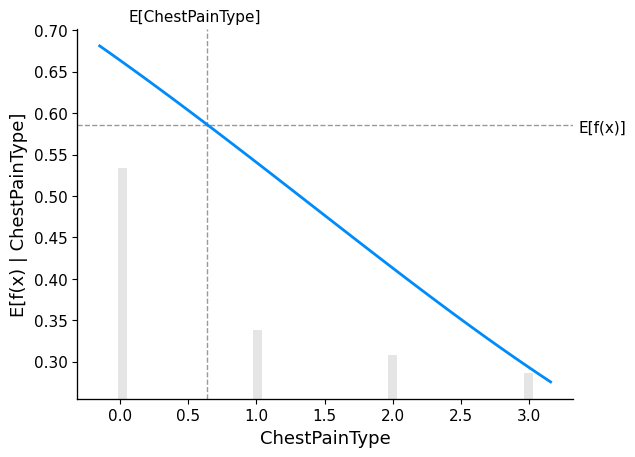

In [62]:
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "ChestPainType",
    model_proba,
    df_test.drop("HeartDisease", axis=1),
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)